In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pickle

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import os.path as osp
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #LDA
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel #para seleccionar los coeficientes de lasso
from sklearn.metrics import roc_auc_score, f1_score
from sklearn import set_config
set_config(display="diagram")

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
!pip install fastai wwf bayesian-optimization -q --upgrade
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
print(os.path.isfile("df_train.parquet")) #valida si el archivo existe

True


In [3]:
#DATA_DIR = "/kaggle/input/fa-ii-2024-ii-flujos-de-modelos-tradicionales/"
#df = pd.read_parquet(osp.join(DATA_DIR, "df_train.parquet"))
df = pd.read_parquet("df_train.parquet") #Cargamos datos de entrenamiento
df

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.0,3.0,3.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
11528,6.0,1.0,1.0,2,0.5,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
26630,1.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
12586,6.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
11225,3.0,0.0,2.0,1,1.0,NaN,0.0,NaN,NaN,1.0,...,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7141,0.0,0.0,1.0,3,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,6628.571429,-15466.666667,4.640000e+04
15417,6.0,0.0,3.0,1,1.0,NaN,0.0,NaN,NaN,1.0,...,2,2,2,2,2,2,0,36161.142857,-66307.333333,9.038500e+04
19389,8.0,2.0,2.0,1,0.0,NaN,0.0,NaN,NaN,0.0,...,2,2,2,2,2,2,0,15912.885714,16190.066667,1.078278e+05


In [4]:
df.info() #Información del dataset de entrenamiento

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 16484 to 9409
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   23494 non-null  float64
 1   MEDICINA ESPECIALIZADA         23494 non-null  float64
 2   MEDICINA GENERAL               23494 non-null  float64
 3   Cant_gr_flia                   23494 non-null  int64  
 4   Cant_riesgos_flia_mean         23494 non-null  float64
 5   min_Tiempo_CP_Fliar            8 non-null      float64
 6   Cant_Fliar_CP                  23494 non-null  float64
 7   psa_max_gr_flia                164 non-null    float64
 8   psa_min_gr_flia                164 non-null    float64
 9   Cant_Fliar_riesgos             23494 non-null  float64
 10  cantidad_serv_flia             23494 non-null  float64
 11  Pendiente_flia                 23494 non-null  float64
 12  Intercepto_flia                23494 non-null  f

In [5]:
#DATA_DIR = "/kaggle/input/fa-ii-2024-ii-flujos-de-modelos-tradicionales/"
#df1 = pd.read_parquet(osp.join(DATA_DIR, "df_test.parquet"))
#Dataset para test
df1 = pd.read_parquet("df_test.parquet") #Cargamos el dataset de test
df1

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
12596,2.0,4.0,2.0,2,0.000000,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,5.421180e+06,-1.256617e+07,9.611937e+06
29326,4.0,0.0,1.0,1,0.000000,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,-9.504343e+03,5.997787e+04,8.013800e+04
24338,0.0,0.0,1.0,2,0.000000,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,2.477143e+03,-5.780000e+03,1.734000e+04
11167,1.0,0.0,0.0,1,0.000000,NaN,0.0,NaN,NaN,0.0,...,1,0,1,0,1,0,0,3.597143e+03,-8.393333e+03,2.518000e+04
22074,36.0,0.0,1.0,3,0.666667,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,-9.042514e+03,6.309881e+05,5.993393e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6392,35.0,2.0,0.0,4,0.500000,NaN,0.0,NaN,NaN,1.0,...,2,2,2,2,2,2,2,6.545311e+04,2.384719e+05,5.610694e+05
5998,4.0,3.0,1.0,1,0.000000,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,-5.250857e+03,5.109600e+04,4.907700e+04
12654,0.0,0.0,1.0,2,0.000000,NaN,0.0,NaN,NaN,0.0,...,0,1,0,0,0,0,0,2.438571e+03,-5.690000e+03,1.707000e+04


In [6]:
df1.info() #Información del dataset de test

<class 'pandas.core.frame.DataFrame'>
Index: 10069 entries, 12596 to 22281
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   10069 non-null  float64
 1   MEDICINA ESPECIALIZADA         10069 non-null  float64
 2   MEDICINA GENERAL               10069 non-null  float64
 3   Cant_gr_flia                   10069 non-null  int64  
 4   Cant_riesgos_flia_mean         10069 non-null  float64
 5   min_Tiempo_CP_Fliar            2 non-null      float64
 6   Cant_Fliar_CP                  10069 non-null  float64
 7   psa_max_gr_flia                76 non-null     float64
 8   psa_min_gr_flia                76 non-null     float64
 9   Cant_Fliar_riesgos             10069 non-null  float64
 10  cantidad_serv_flia             10069 non-null  float64
 11  Pendiente_flia                 10069 non-null  float64
 12  Intercepto_flia                10069 non-null  

In [7]:
X, y = df.drop(columns="Target"), df["Target"] #Partimos el dataset de entrenamiento en X y y
y.value_counts(True) * 100 #Proporción de la variable target en el dataset de entrenamiento

Target
0    71.537414
1    28.462586
Name: proportion, dtype: float64

In [8]:
porcetaje_de_nulidad = (
    X.isnull() #Crea un DataFrame booleano donde cada elemento es True si el valor correspondiente en X es nulo (NaN) y False si no lo es.
    .apply(lambda s: s.value_counts(True)).T #Apply recorre cada columna y aplica una función lambda a cada columna.
    #.apply(lambda s: s.value_counts(True)): Para cada columna (representada por s), se cuenta la frecuencia de los valores True (nulos) y False (no nulos).
    #value_counts(True) devuelve la proporción (frecuencia) de ambos.
    #T: Transpone el DataFrame resultante para que las columnas sean ahora 'not_null' y 'null', y las filas sean los nombres de las columnas aaoriginales de X.
)

porcetaje_de_nulidad.columns = ['not_null', 'null'] #Renombramos las columnas del DataFrame por 'not_null' y 'null'
variables_muy_nulas = porcetaje_de_nulidad.query('null > 0.7').index #Seleccionamos las variables que tienen más del 70% de nulos y guarda los nombres de esas columnas en la variable variables_muy_nulas.

In [11]:
porcetaje_de_nulidad.head(10)

,not_null,null
MEDICAMENTOS,1.000000,NaN
MEDICINA ESPECIALIZADA,1.000000,NaN
MEDICINA GENERAL,1.000000,NaN
Cant_gr_flia,1.000000,NaN
Cant_riesgos_flia_mean,1.000000,NaN
min_Tiempo_CP_Fliar,0.000341,0.999659
Cant_Fliar_CP,1.000000,NaN
psa_max_gr_flia,0.006981,0.993019
psa_min_gr_flia,0.006981,0.993019
Cant_Fliar_riesgos,1.000000,NaN


In [9]:
variables_muy_nulas

Index(['min_Tiempo_CP_Fliar', 'psa_max_gr_flia', 'psa_min_gr_flia',
       'PERDIDA_DE_PESO'],
      dtype='object')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [31]:
numericas = X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19969 entries, 18135 to 2509
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   19969 non-null  float64
 1   MEDICINA ESPECIALIZADA         19969 non-null  float64
 2   MEDICINA GENERAL               19969 non-null  float64
 3   Cant_gr_flia                   19969 non-null  int64  
 4   Cant_riesgos_flia_mean         19969 non-null  float64
 5   min_Tiempo_CP_Fliar            7 non-null      float64
 6   Cant_Fliar_CP                  19969 non-null  float64
 7   psa_max_gr_flia                143 non-null    float64
 8   psa_min_gr_flia                143 non-null    float64
 9   Cant_Fliar_riesgos             19969 non-null  float64
 10  cantidad_serv_flia             19969 non-null  float64
 11  Pendiente_flia                 19969 non-null  float64
 12  Intercepto_flia                19969 non-null  f

In [32]:
var_numericas = X_train.select_dtypes('number').columns
var_categoricas = X_train.select_dtypes('object').columns

In [33]:
print(y_train.value_counts(True)*100)  #Cuenta la proporción entre 0 y 1 de y train
print(y_test.value_counts(True)*100)  #Cuenta la proporción entre 0 y 1 de y test

Target
0    71.590966
1    28.409034
Name: proportion, dtype: float64
Target
0    71.234043
1    28.765957
Name: proportion, dtype: float64


# Data Processing

In [34]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, var_numericas),
        ("cat", categorical_transformer, var_categoricas),
    ]
)

In [35]:
#Definición de la función:
#def: Indica que se está definiendo una función.
#add_model(data_pipeline, model): La función toma dos parámetros
#data_pipeline: Un objeto de tipo Pipeline que contiene pasos para preprocesar los datos.
#model: Un objeto que representa el modelo de machine learning que se desea utilizar.
#-> Pipeline: Esto es una anotación de tipo que indica que la función devolverá un objeto de tipo Pipeline.

def add_model(data_pipeline, model) -> Pipeline:
    whole_pipeline = Pipeline([
        ("data_pipeline", data_pipeline),
        ("model", model)
    ])
    return whole_pipeline



data_pipeline = Pipeline(steps=[
    ("data_processor", preprocessor),
    #("pca", PCA()),
])

model_kwargs = dict(
        kernel = 'rbf',
        C = 1.0,
        #probability = True
    )

pipeline = add_model(data_pipeline, LogisticRegression()) ## SVC(**model_kwargs)
pipeline

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   Index(['MEDICAMENTOS', 'MEDICINA ESPECIALIZADA', 'MEDICINA GENERAL',
       'Cant_gr_flia', 'Cant_riesgos_flia_mean', 'min_Tiempo_CP_Fliar',
       'Cant_Fliar_CP', 'psa_max_gr...
       'AGRUPACION_DIASTOLICA', 'parentesco', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'HIPERTENSION',
       'HIPERTENSION_FAMILIAR', 'DIABETES', 'DIABETES_FAMILIAR', 'CORONARIOS',
       'CORONARIOS_FAMILIAR', 'CEREBRAL', 'CEREBRAL_FAMILIAR',
       'ENFERMEDAD_RENAL', 'ENFERMEDAD_RENAL_FAMILIAR',
       'OTROS_ANTECEDENTES_VASCULARES'],
      dtype='object'))]))])),
                ('model', LogisticRegression())])

In [36]:
#Guardamos el pipeline en un archivo llamado pipeline.pkl
with open("pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)
#with: Este es un contexto que asegura que el archivo se cierre automáticamente después de que se complete la operación, incluso si ocurre un error durante la escritura.
#open("pipeline.pkl", "wb"): Abre (o crea si no existe) un archivo llamado pipeline.pkl en modo de escritura binaria ("wb").
#"wb": Indica que el archivo se abrirá en modo escritura y se tratará como un archivo binario. Esto es importante porque los objetos de Python pueden contener datos que no son simplemente texto (por ejemplo, matrices o estructuras de datos complejas).
#as f: :Esto asigna el objeto de archivo abierto a la variable f, que se puede usar dentro del bloque with para realizar operaciones de lectura/escritura en el archivo.
#pickle.dump(pipeline, f): Esta función toma dos argumentos: el objeto que deseas guardar (en este caso, pipeline) y el objeto de archivo f donde se guardará el objeto.
#pipeline: Es el objeto que se está guardando. Este objeto podría ser, por ejemplo, un modelo de machine learning, un pipeline de procesamiento de datos o cualquier otro objeto de Python que se pueda serializar.
#La función dump serializa el objeto y lo escribe en el archivo abierto.

#En resumen, este código guarda el objeto pipeline en un archivo llamado pipeline.pkl 
# en formato binario utilizando la biblioteca pickle. 
# Esto permite que el objeto se pueda cargar más tarde sin tener que volver a crear o recalcular su estado. 
# El uso de pickle es común en el machine learning para guardar modelos entrenados o pipelines de procesamiento 
# para su reutilización en futuras inferencias o análisis.


In [37]:
pipeline.fit(X_train, y_train)

C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   Index(['MEDICAMENTOS', 'MEDICINA ESPECIALIZADA', 'MEDICINA GENERAL',
       'Cant_gr_flia', 'Cant_riesgos_flia_mean', 'min_Tiempo_CP_Fliar',
       'Cant_Fliar_CP', 'psa_max_gr...
       'AGRUPACION_DIASTOLICA', 'parentesco', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'HIPERTENSION',
       'HIPERTENSION_FAMILIAR', 'DIABETES', 'DIABETES_FAMILIAR', 'CORONARIOS',
       'CORONARIOS_FAMILIAR', 'CEREBRAL', 'CEREBRAL_FAMILIAR',
       'ENFERMEDAD_RENAL', 'ENFERMEDAD_RENAL_FAMILIAR',
       'OTROS_ANTECEDENTES_VASCULARES'],
      dtype='object'))]))])),
                ('model', LogisticRegression())])

In [38]:
test_preds = pipeline.predict_proba(X_test)[:, 1]
train_preds = pipeline.predict_proba(X_train)[:, 1]

In [39]:
test_f1 = roc_auc_score(y_test, test_preds)
train_f1 = roc_auc_score(y_train, train_preds)
print(f"Train roc_auc: {train_f1}")
print(f"Test roc_auc: {test_f1}")

Train roc_auc: 0.6260989108818206
Test roc_auc: 0.6252936782299893


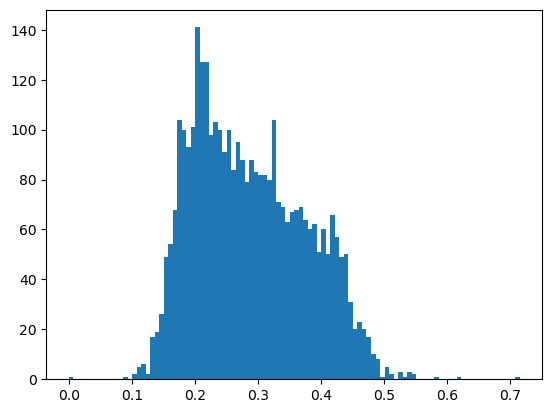

In [40]:
plt.hist(test_preds, bins=100)
plt.show()

In [41]:
pipeline.fit(X, y)

C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   Index(['MEDICAMENTOS', 'MEDICINA ESPECIALIZADA', 'MEDICINA GENERAL',
       'Cant_gr_flia', 'Cant_riesgos_flia_mean', 'min_Tiempo_CP_Fliar',
       'Cant_Fliar_CP', 'psa_max_gr...
       'AGRUPACION_DIASTOLICA', 'parentesco', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'HIPERTENSION',
       'HIPERTENSION_FAMILIAR', 'DIABETES', 'DIABETES_FAMILIAR', 'CORONARIOS',
       'CORONARIOS_FAMILIAR', 'CEREBRAL', 'CEREBRAL_FAMILIAR',
       'ENFERMEDAD_RENAL', 'ENFERMEDAD_RENAL_FAMILIAR',
       'OTROS_ANTECEDENTES_VASCULARES'],
      dtype='object'))]))])),
                ('model', LogisticRegression())])

In [42]:
test_df = pd.read_parquet("df_test.parquet")
submission_pred = pipeline.predict_proba(test_df)[:, 1]
#submission_pred_bool = submission_pred>best_th
#submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred))


In [43]:
submission.to_csv("submission.csv", index=False)